<h1 align='center'> E-commerce product buyer session prediction </h1>

## Contents

- [Problem Statement](#problem-statement)
- [Data Summary](#data-summary)
- [Approach Overview](#approach-overview)
- [Installation](#installations)
- [Imports](#imports)
- [Data Loader](#data-loader)
- [Exploratory Data Analysis(EDA)](#exploratory-data-analysis(EDA))
- [Feature Engineering/Extraction](#feature-engineeringextraction)
- [Feature Encoding](#feature-encoding)
- [Feature Selection](#feature-selection)
- [Modeling](#modeling)
- [Model Evaluation/Selection](#model-evaluationselection)
- [Hyper-parameter Tuning](#models-hyper-parameter-tuning)
- [Prediction Over Test Set](#predictions-over-test-set)
- [Neural Network based Modeling](#multilayer-perceptron-model)
    - [Data Preparation](#data-preparation)
    - [Train/Valid Split](#trainvalid-split)
    - [Model Building](#model-building)
    - [Model's Evaluation](#models-evaluation)
    - [Model's Inference](#models-inference)



## Problem Statement

**Predict whether customer purchase a product or not in a session**

## Data Summary

The datasets contain following files

- `train.dat`: 4072954 rows X 5 columns, 1125000 session_ids
- `test.dat`: 1040614 rows X 4 columns, 306825 session_ids
- `sample_submission.csv` - 100X2 (session_id, label columns)

**Columns Summary**

- `session_id` : Represent the unique session a user interected with products and category(s)
- `timestamp` : timestamp
- `category`: category of items, the user interected within that session(could be one or more)
- `item_id_code`: Unique code for each product
- `label`: Target outcome to predict - whether user purchased in that session or not.

## Approach Overview

We can approach this binary predictions via several ways:

- **Clustering :** we can do clustering of session based on given features as buyer session or not and then we can have 2 cluster and for upcoming sessions we can find out which cluster contains smiliar session like this one. We can use some clustering methods like KMeans etc to get the final result.
- **Tabular Classification Problem :** We can construct some manual features out of the given informations and based on it we can get use some popular classifiers like RandomForest or XgBoost to classify a session as a buyer or not. We can also use Multilayer perceptron methods to get the final outcome.
- **Sequenctial Classification Problem :** We can treat the given data as some sort of have temporal relationship and based on it we can have Recurrent Neural Network(RNNs) based Models for classification. For item id cd we can train to get some meaningfull embeddings etc.

In this notebook, I have approached this problem as **Tabular Classification Problem** and have employed classification models like Logistic Regression, Decision Tree Classifier, Random Forest and XGBoost classifiers.

I have also tested out Multi layer perceptron based models.


**Models Deployed:**

- Logistic Regression
- Naive Bayes Classfier
- Decision Trees
- Random Forest
- Adaboost Classifier
- XgBoost
- LightGBM 
- MLPs neural netwrok model


## Installations

In [5]:
!pip install hvplot
#!pip install imblearn
#!pip install xgboost
#!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.3 MB/s eta 0:00:00


## Imports

In [6]:
#for data eda and modeling
import time
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import hvplot.pandas
import matplotlib.pyplot as plt

#for oversampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler


#ml models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import GaussianNB

#for cv and evaluation
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

## Data Loader

In [7]:
#function for reading .dat file

def data_loader(path, delimiter=','):

    df = pd.read_csv(path, delimiter=delimiter, parse_dates=True)

    return df


Define the train and test paths

In [8]:
train_path = "/content/drive/MyDrive/mmt_data_set/train.dat"
test_path = "/content/drive/MyDrive/mmt_data_set/test.dat"

Load the data

In [9]:
train = data_loader(train_path)
test = data_loader(test_path)

<ipython-input-7-90e6d352ef11>:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, delimiter=delimiter, parse_dates=True)


Sanity check over counts and sample rows.

In [10]:
print(f"total number of train rows : {train.shape[0]} and total number of train columns : {train.shape[1]}")
print(f"total number of test rows : {test.shape[0]} and total number of test columns : {test.shape[1]}")

total number of train rows : 4072954 and total number of train columns : 5
total number of test rows : 1040614 and total number of test columns : 4


In [11]:
train.head(5)

,session_id,timestamp,category,item_id_code,label
0,2,2014-04-07T13:56:37.614Z,0,19448,False
1,2,2014-04-07T13:57:19.373Z,0,19448,False
2,2,2014-04-07T13:58:37.446Z,0,40788,False
3,2,2014-04-07T13:59:50.710Z,0,32516,False
4,2,2014-04-07T14:00:38.247Z,0,32522,False


In [12]:
test.head()

,session_id,timestamp,category,item_id_code
0,8685453,2014-08-26T02:44:41.001Z,S,28987
1,8685453,2014-08-26T02:45:59.621Z,S,28988
2,8685453,2014-08-26T02:46:10.164Z,S,28989
3,8755657,2014-08-26T02:52:12.534Z,1,43994
4,8755657,2014-08-26T02:53:37.370Z,1,43994


Test data has one column missing and that is the `label` column. We need to predict that column and append in test set.

Now we have loaded the data, Let's see some basic stats like count, null values counts, and feature level info like data types and their frequencies.

## Exploratory Data Analysis(EDA)

- Getting overall count of data
- Feature level stats
- Unique counts, total counts etc.
- Null values check
- Data types and sample values
- Some graphical visualization of frequency counts etc.

Note that the test data can be treated as unseen data and I will be doing most of pre-processing and all over train set only. Once we are done with train data and satisfied with analysis we can replicate the same for test data as well.

In [13]:
#shape of train data
print(f"Total no. of rows in train {train.shape[0]}")
print(f"Total no. of columns in train {train.shape[1]}")

Total no. of rows in train 4072954
Total no. of columns in train 5


In [14]:
# sample data
train.head(5)

,session_id,timestamp,category,item_id_code,label
0,2,2014-04-07T13:56:37.614Z,0,19448,False
1,2,2014-04-07T13:57:19.373Z,0,19448,False
2,2,2014-04-07T13:58:37.446Z,0,40788,False
3,2,2014-04-07T13:59:50.710Z,0,32516,False
4,2,2014-04-07T14:00:38.247Z,0,32522,False


Okay so we have some date columns and label is binary(0/1)

In [15]:
#get the unqiue values on feature level
train.nunique()

session_id      1125000
timestamp       4071657
category            255
item_id_code      34909
label                 2
dtype: int64

Cardinality for `item_id_code`, `session_id` and `timestamp` is really high.

In [16]:
#data type summary
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072954 entries, 0 to 4072953
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   session_id    int64 
 1   timestamp     object
 2   category      object
 3   item_id_code  int64 
 4   label         bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 128.2+ MB


In [17]:
#check for null values in each predictors
train.isnull().sum()

session_id      0
timestamp       0
category        0
item_id_code    0
label           0
dtype: int64

oho we don't have any null values in the data so no need to worry about null values imputations.

Since we have just 5 features including the target/label, we can perform feature level stats one by one.

### session_id

In [18]:
session = train[['session_id', 'label']]

print(f"Minimum session_id : {session['session_id'].min()}")
print(f"Maximum session_id : {session['session_id'].max()}")

Minimum session_id : 2
Maximum session_id : 8667979


In [19]:
session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072954 entries, 0 to 4072953
Data columns (total 2 columns):
 #   Column      Dtype
---  ------      -----
 0   session_id  int64
 1   label       bool 
dtypes: bool(1), int64(1)
memory usage: 35.0 MB


Let's see how many session are purchased session and how many are not.

We need to do groupby operation since we have multiple entries for same `session_id`.

In [20]:
#agg over session_id
session = session.groupby('session_id').agg(lambda x : list(x)[0]) #for each session we have either true or false not both
purchased_session = session.query("label==True")
non_purchased_session = session.query("label==False")

In [21]:
print(f"Total no. of purchased session : {len(purchased_session)} ")
print(f"Total no. of non purchased session : {len(non_purchased_session)} ")
print(f"Ratio of buyer to non-buyer session : {len(purchased_session)/len(non_purchased_session)}")

Total no. of purchased session : 62666 
Total no. of non purchased session : 1062334 
Ratio of buyer to non-buyer session : 0.058988980866657756


So for every 100 non-buyer session we have 5 buyer session. This means we need to deal with this much class imbalance very carefully.

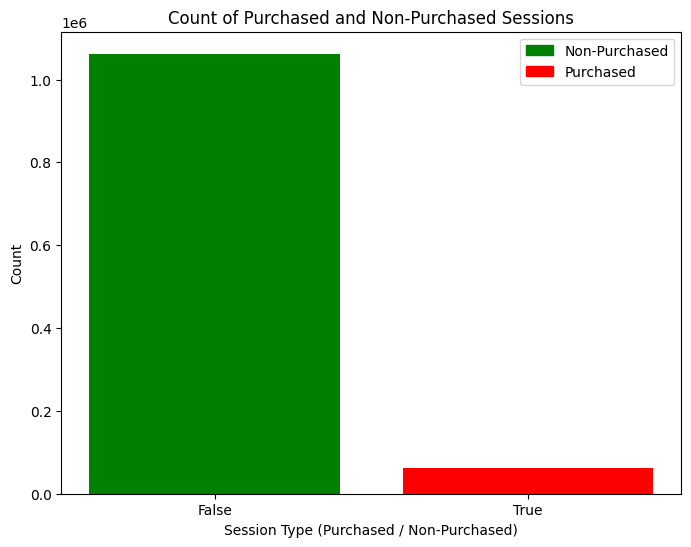

In [22]:
session_counts = session['label'].value_counts()

# bar chart
plt.figure(figsize=(8, 6))
plt.bar(session_counts.index.astype(str), session_counts.values, color=['green', 'red'])
plt.xlabel('Session Type (Purchased / Non-Purchased)')
plt.ylabel('Count')
plt.title('Count of Purchased and Non-Purchased Sessions')
legend_labels = ['Non-Purchased', 'Purchased']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in ['green', 'red']]
plt.legend(legend_handles, legend_labels)
plt.show()

Above distribution seems totally skewed. Purchase sessions count is in minority. We need to take of this class imbalance scenario.

**Summary of feature session_id**

- Default datatype of `session_id` is `int64` and it seems correct.
- High cardinality
- Minimum value : 2 and Maximum value : 8667979
- We have either a session as purchased or not.
- Purchased session count is 62666 and for non purchased it is 1062334
- Non purchased session seems overcrowded and should be dealt with carefully since purchased session is in minority and there seems class imbalance.

### Timestamp

This is the important feature. We can derive some extra features using this fearture like date, month etc.


In [23]:
timestamp = train[['session_id', 'timestamp', 'label']]

In [24]:
timestamp.head()

,session_id,timestamp,label
0,2,2014-04-07T13:56:37.614Z,False
1,2,2014-04-07T13:57:19.373Z,False
2,2,2014-04-07T13:58:37.446Z,False
3,2,2014-04-07T13:59:50.710Z,False
4,2,2014-04-07T14:00:38.247Z,False


In [25]:
timestamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072954 entries, 0 to 4072953
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   session_id  int64 
 1   timestamp   object
 2   label       bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 66.0+ MB


The default data type is of `object` but we need to convert it into `timestamp` data type to enable some data time inbuilt features in Pandas.

In [26]:
# Convert the 'timestamp' column to datetime format
timestamp['timestamp'] = pd.to_datetime(timestamp['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')

timestamp.head()


<ipython-input-26-51b989a4ccfe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp['timestamp'] = pd.to_datetime(timestamp['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')


,session_id,timestamp,label
0,2,2014-04-07 13:56:37.614,False
1,2,2014-04-07 13:57:19.373,False
2,2,2014-04-07 13:58:37.446,False
3,2,2014-04-07 13:59:50.710,False
4,2,2014-04-07 14:00:38.247,False


**session duration**

We can use `timestamp` feature to get session_duration like how long a particular session lasted. It seems reasonable to assume session with more duration likely to be a purchasing session but this needs to derive from the data.



In [27]:
# Group by 'session_id' and aggregate session duration, maximum timestamp, and label
agg_timestamp = timestamp.groupby('session_id').agg({
    'timestamp': ['max', 'min'],
    'label': 'first'  # Assuming label is the same for all rows in a session
})
agg_timestamp.columns = ['max_timestamp', 'min_timestamp', 'label']

In [28]:
agg_timestamp.head()

,max_timestamp,min_timestamp,label
session_id,,,
2,2014-04-07 14:02:36.889,2014-04-07 13:56:37.614,False
23,2014-04-04 07:56:48.356,2014-04-04 07:43:18.598,False
27,2014-04-07 08:01:51.327,2014-04-07 07:40:12.650,False
36,2014-04-06 20:01:30.080,2014-04-06 20:00:18.669,False
41,2014-04-06 08:36:41.495,2014-04-06 08:34:38.902,False


In [29]:
agg_timestamp['session_duration'] = agg_timestamp['max_timestamp'] - agg_timestamp['min_timestamp']

agg_timestamp.head()

,max_timestamp,min_timestamp,label,session_duration
session_id,,,,
2,2014-04-07 14:02:36.889,2014-04-07 13:56:37.614,False,0 days 00:05:59.275000
23,2014-04-04 07:56:48.356,2014-04-04 07:43:18.598,False,0 days 00:13:29.758000
27,2014-04-07 08:01:51.327,2014-04-07 07:40:12.650,False,0 days 00:21:38.677000
36,2014-04-06 20:01:30.080,2014-04-06 20:00:18.669,False,0 days 00:01:11.411000
41,2014-04-06 08:36:41.495,2014-04-06 08:34:38.902,False,0 days 00:02:02.593000


Convert `session_duration` into total seconds.

In [30]:
agg_timestamp['session_duration_seconds'] = (agg_timestamp['session_duration'].dt.total_seconds()).astype(int)

agg_timestamp.head()

,max_timestamp,min_timestamp,label,session_duration,session_duration_seconds
session_id,,,,,
2,2014-04-07 14:02:36.889,2014-04-07 13:56:37.614,False,0 days 00:05:59.275000,359
23,2014-04-04 07:56:48.356,2014-04-04 07:43:18.598,False,0 days 00:13:29.758000,809
27,2014-04-07 08:01:51.327,2014-04-07 07:40:12.650,False,0 days 00:21:38.677000,1298
36,2014-04-06 20:01:30.080,2014-04-06 20:00:18.669,False,0 days 00:01:11.411000,71
41,2014-04-06 08:36:41.495,2014-04-06 08:34:38.902,False,0 days 00:02:02.593000,122


In [31]:
#get sessions with maximu duration and minimum duration
agg_timestamp.sort_values(by='session_duration_seconds', ascending=False)


,max_timestamp,min_timestamp,label,session_duration,session_duration_seconds
session_id,,,,,
199474,2014-04-03 20:12:14.799,2014-04-03 06:37:08.500,False,0 days 13:35:06.299000,48906
319634,2014-04-02 03:46:22.583,2014-04-01 15:18:55.330,False,0 days 12:27:27.253000,44847
215229,2014-04-01 16:20:45.344,2014-04-01 06:03:51.241,False,0 days 10:16:54.103000,37014
6164943,2014-07-14 17:46:09.545,2014-07-14 08:39:53.506,False,0 days 09:06:16.039000,32776
4343256,2014-06-06 16:01:09.555,2014-06-06 07:01:57.355,False,0 days 08:59:12.200000,32352
...,...,...,...,...,...
3145772,2014-05-25 10:07:33.228,2014-05-25 10:07:33.228,True,0 days 00:00:00,0
5534446,2014-06-24 12:23:31.472,2014-06-24 12:23:31.472,False,0 days 00:00:00,0
6232604,2014-07-18 13:28:14.953,2014-07-18 13:28:14.953,False,0 days 00:00:00,0


- Maximum session durations : 48906.299sec
- Minimum session durations : 0.0 secs

Let's visualize the distribution of session durations

In [32]:
agg_timestamp.reset_index().groupby('session_duration_seconds')['session_id'].agg('count').reset_index()

,session_duration_seconds,session_id
0,0,133647
1,1,16421
2,2,7832
3,3,4369
4,4,2721
...,...,...
7203,32352,1
7204,32776,1
7205,37014,1
7206,44847,1


So most of the session have `session_duration_minuts` either 0 or 1 minute and for higher durations we don't have many sessions.

In [33]:
#mean, median and mode of session duration
agg_timestamp['session_duration_seconds'].describe()

count    1.125000e+06
mean     3.883033e+02
std      7.493250e+02
min      0.000000e+00
25%      3.800000e+01
50%      1.350000e+02
75%      3.950000e+02
max      4.890600e+04
Name: session_duration_seconds, dtype: float64

**Timestamp sub-features**

It might be possible on weekends people are more prone to buy a product than weekdays and similar logic might be applicable on whether it is evening or morning or whether it is a summer or winter etc.

Derive the follwoing columns from `timestamp` features.

- Month
- Day of the Month
- AM or PM
- Weekdays or Weekends
- hours/minuts

In [34]:
agg_timestamp.columns

Index(['max_timestamp', 'min_timestamp', 'label', 'session_duration',
       'session_duration_seconds'],
      dtype='object')

In [35]:
agg_timestamp = agg_timestamp[['max_timestamp', 'session_duration', 'session_duration_seconds', 'label']]
#keep the max timesamp as timestamp column we could have taken mean of max and min timestamp as avg value
agg_timestamp.rename(columns = {"max_timestamp":"timestamp"},inplace=True)

<ipython-input-35-a7791346c525>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_timestamp.rename(columns = {"max_timestamp":"timestamp"},inplace=True)


Populate date time features and explore how they are correlated with purchasing and non purchasing session.

In [36]:
agg_timestamp.columns

Index(['timestamp', 'session_duration', 'session_duration_seconds', 'label'], dtype='object')

In [37]:
# Extract various components
agg_timestamp['hour'] = agg_timestamp['timestamp'].dt.hour
agg_timestamp['month'] = agg_timestamp['timestamp'].dt.month
agg_timestamp['day'] = agg_timestamp['timestamp'].dt.day
agg_timestamp['minute'] = agg_timestamp['timestamp'].dt.minute
agg_timestamp['week_day_number'] = agg_timestamp['timestamp'].dt.dayofweek
agg_timestamp['week_number'] = agg_timestamp['timestamp'].dt.strftime('%U')

# Determine whether it's a weekend (Saturday or Sunday)
agg_timestamp['is_weekend'] = agg_timestamp['timestamp'].dt.dayofweek.isin([5, 6])

# Determine whether it's AM or PM
agg_timestamp['ampm'] = agg_timestamp['timestamp'].dt.strftime('%p')

In [38]:
agg_timestamp.head()

,timestamp,session_duration,session_duration_seconds,label,hour,month,day,minute,week_day_number,week_number,is_weekend,ampm
session_id,,,,,,,,,,,,
2,2014-04-07 14:02:36.889,0 days 00:05:59.275000,359,False,14,4,7,2,0,14,False,PM
23,2014-04-04 07:56:48.356,0 days 00:13:29.758000,809,False,7,4,4,56,4,13,False,AM
27,2014-04-07 08:01:51.327,0 days 00:21:38.677000,1298,False,8,4,7,1,0,14,False,AM
36,2014-04-06 20:01:30.080,0 days 00:01:11.411000,71,False,20,4,6,1,6,14,True,PM
41,2014-04-06 08:36:41.495,0 days 00:02:02.593000,122,False,8,4,6,36,6,14,True,AM


Let's explore the impact of weekend and months on purchasing sessions.

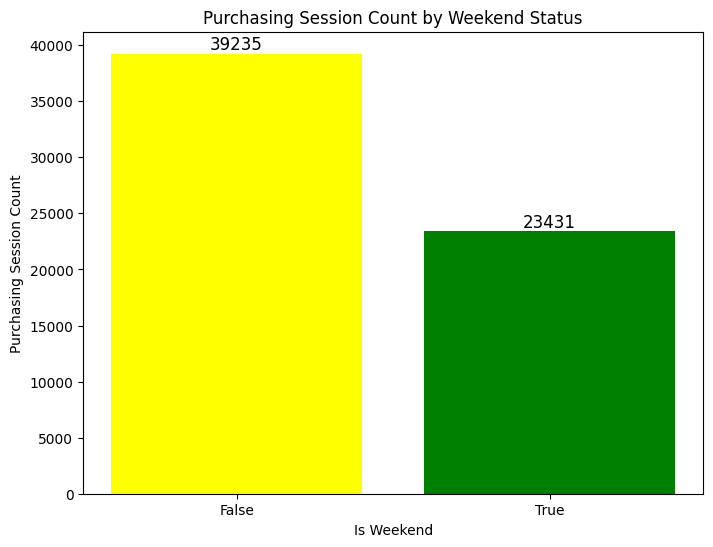

In [39]:
#get all the purchanging sessions
agg_timestamp_p = agg_timestamp.query("label==True")

#impact of weekend
tmp_df = agg_timestamp_p.groupby('is_weekend')['label'].agg('sum').reset_index()
tmp_df.columns = ['is_weekend', 'purchasing_session_count']

#plot the above stats
plt.figure(figsize=(8, 6))
bars = plt.bar(tmp_df['is_weekend'].astype(str), tmp_df['purchasing_session_count'], color=['yellow', 'green'])
plt.xlabel('Is Weekend')
plt.ylabel('Purchasing Session Count')
plt.title('Purchasing Session Count by Weekend Status')
# Annotate the count values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, str(int(yval)), ha='center', va='bottom', fontsize=12)

plt.show()

From above status it is quite evident that on weekend we have most of the purchasing sessions.

- Total purchasing session = 62666
- Purching session count on weekend = 23431
- Purching session count on weekdays = 39235
- % of purchasing session on weekends = 37.37

We just have two days in weekend group but it comprises 37% of all the purchasing sessions. It can be play vital role on final predictions.



**Impact of AM and PM**

In the above section I illustrated the impact of weekend on consumer behaviour. In this section I will be investigating how AM or PM of the day is impacting the consumer buying behaviour.

Intution wise people are more prone to buy something in the evening than in the morning.

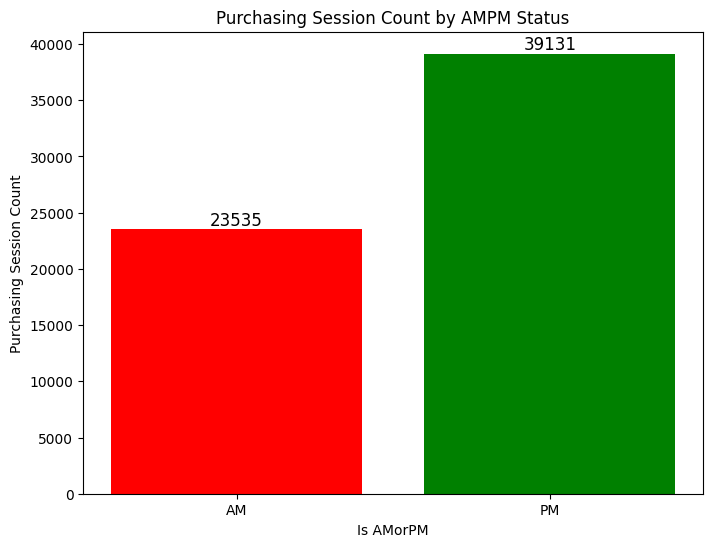

In [40]:
#get all the purchanging sessions
agg_timestamp_p = agg_timestamp.query("label==True")

#impact of weekend
tmp_df = agg_timestamp_p.groupby('ampm')['label'].agg('sum').reset_index()
tmp_df.columns = ['ampm', 'purchasing_session_count']

#plot the above stats
plt.figure(figsize=(8, 6))
bars = plt.bar(tmp_df['ampm'].astype(str), tmp_df['purchasing_session_count'], color=['red', 'green'])
plt.xlabel('Is AMorPM')
plt.ylabel('Purchasing Session Count')
plt.title('Purchasing Session Count by AMPM Status')
# Annotate the count values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, str(int(yval)), ha='center', va='bottom', fontsize=12)

plt.show()

From above status it is quite evident that in PM we have most of the purchasing sessions.

- Total purchasing session = 62666
- Purching session count on AM = 23535
- Purching session count on PM = 39131
- % of purchasing session on PM = 62.44

We can drill down on more granualr level like `morning`, `noon`, `after-noon`, `evening` and `night`. But for time being let's settle with AM/PM division only.

**Impact of Month**

In the above section I illustrated the impact of AM/PM of a day on consumer behaviour. In this section I will be investigating how Month of the session is impacting the consumer buying behaviour.

The intuition behind it is like we might have summer/winter or festive and non-festive session.

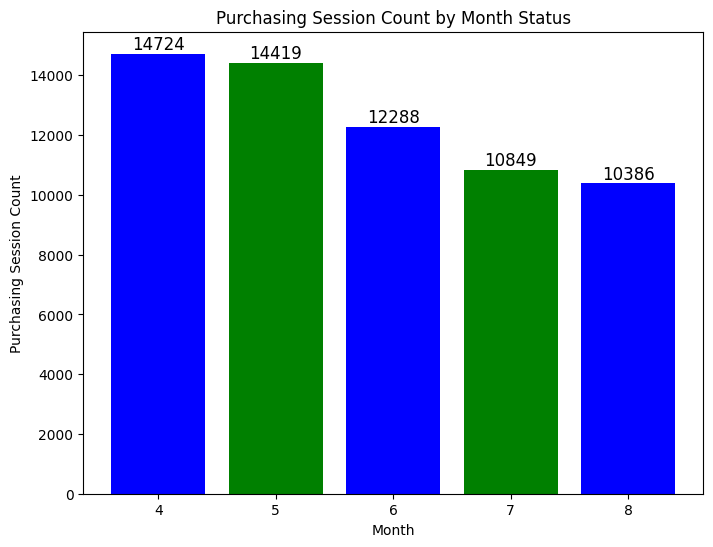

In [41]:
#get all the purchanging sessions
agg_timestamp_p = agg_timestamp.query("label==True")

#impact of weekend
tmp_df = agg_timestamp_p.groupby('month')['label'].agg('sum').reset_index()
tmp_df.columns = ['month', 'purchasing_session_count']

#plot the above stats
plt.figure(figsize=(8, 6))
bars = plt.bar(tmp_df['month'].astype(str), tmp_df['purchasing_session_count'], color=['blue', 'green'])
plt.xlabel('Month')
plt.ylabel('Purchasing Session Count')
plt.title('Purchasing Session Count by Month Status')
# Annotate the count values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, str(int(yval)), ha='center', va='bottom', fontsize=12)

plt.show()

From above graph we can deduce intial months had more purchasing session count than the upcoming months.

**Impact of Week day number**

In the above section I illustrated the impact of month number of a day on consumer behaviour. In this section I will be investigating how weekday number of the session is impacting the consumer buying behaviour.

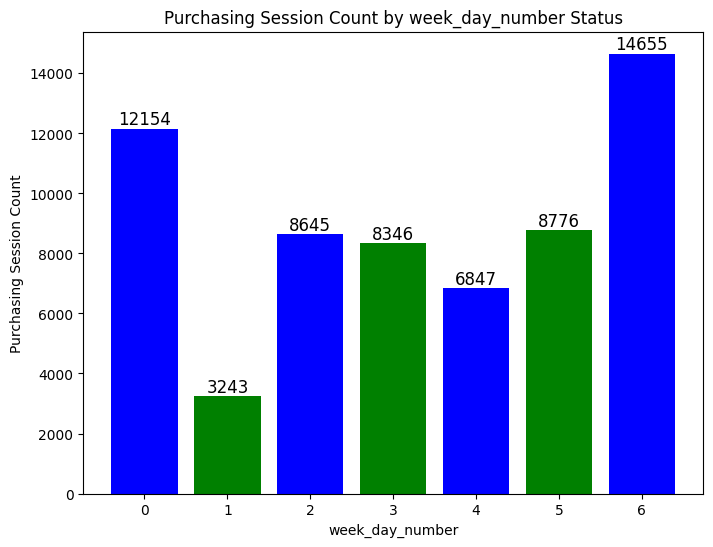

In [42]:
#get all the purchanging sessions
agg_timestamp_p = agg_timestamp.query("label==True")

#impact of weekend
tmp_df = agg_timestamp_p.groupby('week_day_number')['label'].agg('sum').reset_index()
tmp_df.columns = ['week_day_number', 'purchasing_session_count']

#plot the above stats
plt.figure(figsize=(8, 6))
bars = plt.bar(tmp_df['week_day_number'].astype(str), tmp_df['purchasing_session_count'], color=['blue', 'green'])
plt.xlabel('week_day_number')
plt.ylabel('Purchasing Session Count')
plt.title('Purchasing Session Count by week_day_number Status')
# Annotate the count values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, str(int(yval)), ha='center', va='bottom', fontsize=12)

plt.show()

On some week days like Monday we have quite a few buyer-sessions. Among the week days on friday we have most of the purchasing sessions.

**Impact of Hours**

In the above section I illustrated the impact of weekday number of a day on consumer behaviour. In this section I will be investigating how hours of the day is impacting the consumer buying behaviour.

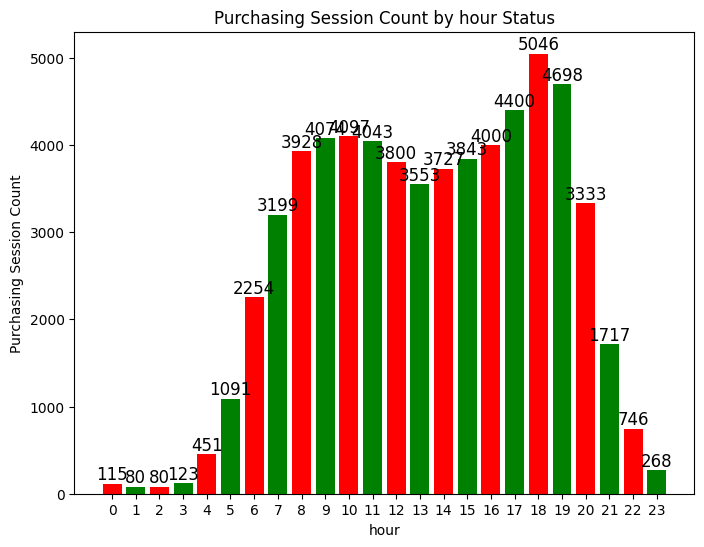

In [43]:
#get all the purchanging sessions
agg_timestamp_p = agg_timestamp.query("label==True")

#impact of weekend
tmp_df = agg_timestamp_p.groupby('hour')['label'].agg('sum').reset_index()
tmp_df.columns = ['hour', 'purchasing_session_count']

#plot the above stats
plt.figure(figsize=(8, 6))
bars = plt.bar(tmp_df['hour'].astype(str), tmp_df['purchasing_session_count'], color=['red', 'green'])
plt.xlabel('hour')
plt.ylabel('Purchasing Session Count')
plt.title('Purchasing Session Count by hour Status')
# Annotate the count values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, str(int(yval)), ha='center', va='bottom', fontsize=12)

plt.show()

oh this seems interesting and agreeing with what we showed in `AMPM` impact analysis. Most of the purchasing is happening during 8AM to 12PM and then 4PM to 8PM.

This is all about `timestamp` feature and we can deduce from above EDA is that, It is quite impactful on deciding whether a session will endup  as purchasing one or not.

### Category

So far we have explored `session_id` and `timestamp`. In this section I will be looking at `category` column

In [44]:
category = train[['session_id', 'category', 'label']].drop_duplicates()
category['category'] = category['category'].astype('str')
category.head()


,session_id,category,label
0,2,0,False
6,23,0,False
10,27,0,False
20,36,0,False
22,41,0,False


In [45]:
#Total number of unique categories
category.nunique()

session_id    1125000
category          254
label               2
dtype: int64

**Total number of unique categories: 254**


In [46]:
category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245139 entries, 0 to 4072953
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   session_id  1245139 non-null  int64 
 1   category    1245139 non-null  object
 2   label       1245139 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 29.7+ MB


In [47]:
category['category'].value_counts()

0             716857
S             310634
1              52476
2              52351
5              21697
               ...  
2088927353         1
2089160873         1
2089583963         1
2089261238         1
2088954981         1
Name: category, Length: 254, dtype: int64

Most viewed is `0` category item.


Let's see out of 254 categories how many were never even in purchasing session.

In [48]:
category_agg = category.groupby('category')['label'].agg('sum').reset_index()

category_agg.columns = ['category', 'total_purchasing_count']

category_agg.head()

,category,total_purchasing_count
0,0,42418
1,1,4422
2,10,423
3,11,240
4,12,106


Most bought category was `0`. and 2nd most is of category `1`.

Okay let's analysis the buy vs view ration for each category like which category has most buy vs view ratio.

In [49]:
buyer_category_agg = category.query("label==True").groupby('category')['label'].agg('count').reset_index()
non_buyer_category_agg = category.query("label==False").groupby('category')['label'].agg('count').reset_index()
buyer_category_agg.columns = ['category', 'buy_count']
non_buyer_category_agg.columns = ['category', 'non_buy_count']

res = buyer_category_agg.merge(non_buyer_category_agg, on='category', how='inner')

#populate ratio percentage
res["buy_vs_non_buy_prct"] = (res['buy_count']/res['non_buy_count'])*100

res.sort_values(by='buy_vs_non_buy_prct', ascending=False).query("buy_count>10")



,category,buy_count,non_buy_count,buy_vs_non_buy_prct
95,3,2972,17675,16.814710
2,10,423,2585,16.363636
4,12,106,779,13.607189
27,2088973177,15,119,12.605042
56,2089322935,14,124,11.290323
54,2089318666,18,163,11.042945
103,9,389,4124,9.432590
1,1,4422,48054,9.202148
3,11,240,2759,8.698804
50,2089286907,12,145,8.275862


**Frequenct bought categories list**

Let's get a frequenct category list where `buy_vs_non_buy_prct >= 10`

In [50]:
frequent_bought_categories = res.query("buy_vs_non_buy_prct>=15")['category'].values
frequent_bought_categories

array(['10', '2088884272', '2088923475', '2088937230', '2088962267',
       '2088962268', '2088966382', '2088995234', '2089074450',
       '2089080779', '2089134332', '2089134472', '2089155957',
       '2089365270', '2089421923', '2089422231', '2089509047',
       '2089515459', '2089529540', '2089531793', '2089538294',
       '2089543895', '2089574647', '2089584494', '2089615768',
       '2089646261', '3', '5862365', '5862488'], dtype=object)

Save the above frequent categories for future use.

In [51]:
frequent_bought_categories_df = pd.DataFrame({'frequent_bought_categories': frequent_bought_categories})
frequent_bought_categories_df.to_csv("frequent_bought_categories.csv", index=False)

In [52]:
category_agg_p = category_agg.query("total_purchasing_count > 0")
category_agg_np = category_agg.query("total_purchasing_count == 0")

print(f"Total number of catefory having atleast one purchases : {len(category_agg_p)}")
print(f"Total number of catefory having  no purchases : {len(category_agg_np)}")

Total number of catefory having atleast one purchases : 111
Total number of catefory having  no purchases : 143


In [53]:
category_agg_np.head()

,category,total_purchasing_count
5,193450130,0
6,193450487,0
7,193452189,0
8,193452342,0
9,193454725,0


Save never bought and atleast once bought categories. We can use them to create binary features.


In [54]:
category_agg_np['category'].to_csv("never_bought_categories.csv", index=False)
category_agg_p['category'].to_csv("atleast_once_bought_categories.csv", index=False)

So out of `254` categories in the entire training set we do have `143` categories that were not involve in any purchasing session.

We can use this information to create binary features of categories like whethere a particular category is there or not in a session.

### Item Id Code

This is last but challenging feature to deal with because it has a lot of unique values.

In [55]:
itm_id = train[['session_id', 'category', 'label', 'item_id_code']].drop_duplicates()
itm_id.head()

,session_id,category,label,item_id_code
0,2,0,False,19448
2,2,0,False,40788
3,2,0,False,32516
4,2,0,False,32522
5,2,0,False,4853


In [56]:
print(f"Total number of unqiue items : {len(set(itm_id['item_id_code']))}")

Total number of unqiue items : 34909


In [57]:
itm_id.describe()

,session_id,item_id_code
count,3.276661e+06,3.276661e+06
mean,4.290056e+06,3.173723e+04
std,2.487708e+06,1.583604e+04
min,2.000000e+00,0.000000e+00
25%,2.140871e+06,1.813300e+04
50%,4.288199e+06,3.990900e+04
75%,6.387637e+06,4.496200e+04
max,8.667979e+06,5.273800e+04


Most bought item in whole data?


In [58]:
itm_id_agg = itm_id.groupby('item_id_code')['label'].agg('sum').reset_index()
itm_id_agg.columns = ['item_id_cd', 'purchasing_instance_count']
itm_id_agg.sort_values(by='purchasing_instance_count', ascending=False)

,item_id_cd,purchasing_instance_count
34898,52706,2172
27919,42127,1730
27923,42131,977
29009,43655,891
27920,42128,819
...,...,...
14591,19973,0
14590,19970,0
14589,19969,0
14586,19966,0


Item with item_id_cd `52706` is most bought item according to train set.

**Never Bought Items**

In [59]:
nvr_bought_itms = itm_id_agg.query("purchasing_instance_count == 0")
nvr_bought_itms.shape

(16842, 2)

Out of 34909 items, 16842 items were never bought in any session. Let's save this info for future use.

In [60]:
#never bought items
nvr_bought_itms['item_id_cd'].to_csv("never_bought_items.csv", index=False)


Atleast once bought items

In [61]:
atleast_once_bought_itms = itm_id_agg.query("purchasing_instance_count > 0")
atleast_once_bought_itms.shape

(18067, 2)

In [62]:
atleast_once_bought_itms['item_id_cd'].to_csv("atleast_once_bought_items.csv", index=False)

**Frequenct item calculation**

Similar to frequenct categories, create a list of frequenct items set.



In [63]:
item_view_count =  train[['label', 'item_id_code']].groupby('item_id_code')['label'].agg('count').reset_index()
item_view_count.columns = ['item_id_code', 'view_count']
item_buy_count = train[['label', 'item_id_code']].groupby('item_id_code')['label'].agg('sum').reset_index()
item_buy_count.columns = ['item_id_code', 'buy_count']

res = item_buy_count.merge(item_view_count, on='item_id_code', how='inner')

res['view_vs_buy_prct'] = (res['buy_count']/res['view_count'])*100
res.sort_values(by='view_vs_buy_prct', ascending=False).query("buy_count>=10 and view_vs_buy_prct>=50")


,item_id_code,buy_count,view_count,view_vs_buy_prct
34039,49492,11,11,100.000000
26613,39825,12,16,75.000000
30332,45041,11,15,73.333333
952,1155,11,17,64.705882
30329,45038,14,22,63.636364
28546,43063,10,16,62.500000
10211,13515,10,16,62.500000
13288,18105,10,16,62.500000
21097,28125,10,17,58.823529
9906,13134,28,49,57.142857


Condition for frequent items : `buy_count>=10 and view_vs_buy_prct>=50`

In [64]:
frqntItems = res.query("buy_count>=10 and view_vs_buy_prct>=50")

frqntItems['item_id_code'].to_csv("frequent_bought_items.csv", index=False)

**Overall Summary**

- Item code has 34909 unique items
- 16842 items are not part of any purchasing session
- 18067 items are part of atleast a purchasing session.

## Feature Engineering/Extraction

Whatever we observed in EDA section we can apply here to create some new features which can play crucial role in prediting the purchasing behaviour.

**Existing features**
- `session_id` - int64
- `timestamp` - timestamp
- `category` - string(object)
- `item_id_code` - object

### New Features

Based on our observations in EDA section, I am creating following new features.

We can divide new features into three categories based on their data type:

- Numeric Features
- Binary Features
- One hot encoded Features


**Numeric Features**

- `item_count` - Total distinct item count in a session
- `category_count` - Total distinct category of item viewd in that session
- `session_duration` - Total duration of the session in seconds
- `item_avg_duration` - Average duration per item per session
- `category_avg_duration` - Average duration per category per session

**Binary Features**

Timestamp related features:

- `session_hour` - Hour of the session like 1AM or 2AM etc
- `session_ampm` - Whether session is AM or PM
- `session_weekend` - Whether session is on weekend or not
- `session_day` - day of the session
- `session_weekday` - day of the week of the session
- `session_timing` - Whether it is morning, evening etc

derived features:

- `nvr_bought_items` - Whether a session contains all non bought items or not(0, 1)
- `all_bought_items` - Whether it contains items that were bought atleast once or not(0,1)
- `nvr_bought_categories` - Whether a session contains all non bought categories(0, 1)
- `all_bought_items` - Whether it contains categories that were bought atleast once(0,1)
- `contains_frequent_items` - Whether a session contains atleast one frequenct items or not
- `contains_frequent_categories` - Whether a session contains atleast one frequenct category or not

encoded Features:
- Create a label encoded column for category feature


Let's write a master function to do all the above extractions and return the final df.

In [65]:
def feature_extraction(df, helper_files_path, train=True):

    """

    function for feature extractions

    input - data frame with following columns session_id, timestamp, category, item_id_code and label(in case of train dataset)

    output - data frame having new columns

    """
    #preprocess the data
    #aggregate the dataset over session id and collect rest of the columns
    #typecaset time stamp columns
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')
    df['category'] = df['category'].astype('str')
    if train:
        df = df.groupby('session_id').agg({'timestamp':['min', 'max'], 'category':set, 'item_id_code':set, 'label':'max'})
        df.columns = ['min_timestamp', 'max_timestamp', 'category_set', 'item_set','label']
    else:
        df = df.groupby('session_id').agg({'timestamp':['min', 'max'], 'category':set, 'item_id_code':set})
        df.columns = ['min_timestamp', 'max_timestamp', 'category_set', 'item_set']
    print(df.columns)
    #numeric features extraction -> - `item_count`, `category_count`,`session_duration, item_avg_duration, category_avg_duration
    df['item_count'] = df['item_set'].apply(lambda x : len(x))
    df['category_count'] = df['category_set'].apply(lambda x:len(x))
    df['session_duration'] = (df['max_timestamp']-df['min_timestamp']).dt.total_seconds().astype('int')
    df['item_avg_duration'] = np.where(df['session_duration'] != 0, df['item_count']/df['session_duration'], 0)
    df['category_avg_duration'] = np.where(df['session_duration'] != 0, df['category_count']/df['session_duration'], 0)

    #binary features
    #timestamp related features -> session_hour, session_ampm, session_weekend, session_day, session_weekday, session_timing
    df.rename(columns={'max_timestamp':'timestamp'}, inplace=True)
    df['session_hour'] = df['timestamp'].dt.hour
    df['session_day'] = df['timestamp'].dt.day
    df['session_weekend'] = df['timestamp'].dt.dayofweek.isin([5, 6])
    df['session_ampm'] = df['timestamp'].dt.strftime('%p')
    df['session_weekday'] = df['timestamp'].dt.dayofweek
    df['session_timing'] = np.where((5 <= df["session_hour"]) & (df["session_hour"] < 12), "Morning", np.where((12 <= df["session_hour"]) & (df["session_hour"] < 17), "Afternoon", np.where((17 <= df["session_hour"]) & (df["session_hour"] < 20), "Evening", "Night")))

    #derived features -> nvr_bought_items,all_bought_items,nvr_bought_categories,all_bought_categories,contains_frequent_items,contains_frequent_categories
    #read the files that we wrote while doing EDA
    atleast_once_bought_categories = set(data_loader(helper_files_path+"atleast_once_bought_categories.csv").values.flatten())
    atleast_once_bought_items = set(data_loader(helper_files_path+"atleast_once_bought_items.csv").values.flatten())
    never_bought_categories = set(data_loader(helper_files_path+"never_bought_categories.csv").values.flatten())
    never_bought_items = set(data_loader(helper_files_path+"never_bought_items.csv").values.flatten())
    frequent_bought_items = set(data_loader(helper_files_path+"frequent_bought_items.csv").values.flatten())
    frequent_bought_categories = set(data_loader(helper_files_path+"frequent_bought_categories.csv").values.flatten())

    df['nvr_bought_items'] = df['item_set'].apply(lambda x : 1 if len(x - never_bought_items)==0 else 0)
    df['all_bought_items'] = df['item_set'].apply(lambda x : 1 if len(x - atleast_once_bought_items)==0 else 0)
    df['nvr_bought_categories'] = df['category_set'].apply(lambda x : 1 if len(x - never_bought_categories)==0 else 0)
    df['all_bought_categories'] = df['category_set'].apply(lambda x : 1 if len(x - atleast_once_bought_categories)==0 else 0)
    df['contains_frequent_categories'] = df['category_set'].apply(lambda x : 1 if len(x & frequent_bought_categories)!=0 else 0)
    df['contains_frequent_items'] = df['item_set'].apply(lambda x : 1 if len(x & frequent_bought_items)!=0 else 0)


    #return the df with required columns
    required_cols = ['item_count', 'category_count','session_duration', 'item_avg_duration', 'category_avg_duration',
                    'session_hour', 'session_ampm', 'session_weekend', 'session_day', 'session_weekday', 'session_timing',
                    'nvr_bought_items','all_bought_items','nvr_bought_categories','all_bought_categories','contains_frequent_items','contains_frequent_categories','label']
    if train:
        return df[required_cols]
    else:
        required_cols.remove('label')
        return df[required_cols]




Test out the above function over some sample data

In [66]:
%%time

train = data_loader(train_path)
#put the helper files path
df_with_features = feature_extraction(train, "")


<ipython-input-7-90e6d352ef11>:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, delimiter=delimiter, parse_dates=True)


Index(['min_timestamp', 'max_timestamp', 'category_set', 'item_set', 'label'], dtype='object')
CPU times: user 1min 33s, sys: 2.12 s, total: 1min 36s
Wall time: 1min 42s


In [ ]:
df_with_features.head()

,item_count,category_count,session_duration,item_avg_duration,category_avg_duration,session_hour,session_ampm,session_weekend,session_day,session_weekday,session_timing,nvr_bought_items,all_bought_items,nvr_bought_categories,all_bought_categories,contains_frequent_items,contains_frequent_categories,label
session_id,,,,,,,,,,,,,,,,,,
2,5,1,359,0.013928,0.002786,14,PM,False,7,0,Afternoon,0,0,0,1,0,0,False
23,1,1,809,0.001236,0.001236,7,AM,False,4,4,Morning,0,1,0,1,0,0,False
27,9,1,1298,0.006934,0.000770,8,AM,False,7,0,Morning,0,1,0,1,0,0,False
36,2,1,71,0.028169,0.014085,20,PM,True,6,6,Night,0,0,0,1,0,0,False
41,1,1,122,0.008197,0.008197,8,AM,True,6,6,Morning,0,1,0,1,0,0,False


It seems working as expected.

## Feature Encoding

We are done with feature extraction, now in order to feed the above data to ML models we need to make sure all the values are encoded into integers.

In the dataset we have some categorical columns as well. We can use one hot encoding and label encoding if possible to get encoding done. For integer columns we don't need encoding at all, we can directly feed them to algorithms if we wish.

In [ ]:
df_with_features.dtypes

item_count                        int64
category_count                    int64
session_duration                  int64
item_avg_duration               float64
category_avg_duration           float64
session_hour                      int64
session_ampm                     object
session_weekend                    bool
session_day                       int64
session_weekday                   int64
session_timing                   object
nvr_bought_items                  int64
all_bought_items                  int64
nvr_bought_categories             int64
all_bought_categories             int64
contains_frequent_items           int64
contains_frequent_categories      int64
label                              bool
dtype: object

Numeric features:
- item_count             
- category_count         
- session_duration
- item_avg_duration
- category_avg_duration

Categorical features:

- session_hour                  
- session_ampm             
- session_weekend         
- session_day             
- session_weekday           
- session_timing   
- nvr_bought_items        
- all_bought_items      
- nvr_bought_categories  
- all_bought_categories  
- contains_frequent_items
- contains_frequent_categories

Although we have numerous categorical columns but most of them has already numeric values. Only these three columns `'session_ampm', 'session_timing', 'label'` have non-numeric values.

Note that the `session_hour`,`session_day`, `session_weekday` can be transformed into onehot encoding fashion, right now the are like label encoded.





In [67]:
def encode_df(df, train = True):

    """

    function for encoding features

    input - data frame

    output - data frame having encoded column values

    """
    #encode label in case of training
    if train:

        df['label'] = df['label'].replace({True:1, False:0})
    #encode session timing - one hot encoding
    df = pd.get_dummies(df, columns=['session_timing'], prefix='session_timing')
    #encode ampm columns
    df['session_ampm'] = df['session_ampm'].replace({"AM":0, "PM":1})
    #encode
    df['session_weekend'] = df['session_weekend'].replace({True:1, False:0})

    return df


In [ ]:
encoded_df = encode_df(df_with_features)

encoded_df.head()

,item_count,category_count,session_duration,item_avg_duration,category_avg_duration,session_hour,session_ampm,session_weekend,session_day,session_weekday,...,all_bought_items,nvr_bought_categories,all_bought_categories,contains_frequent_items,contains_frequent_categories,label,session_timing_Afternoon,session_timing_Evening,session_timing_Morning,session_timing_Night
session_id,,,,,,,,,,,,,,,,,,,,,
2,5,1,359,0.013928,0.002786,14,1,0,7,0,...,0,0,1,0,0,0,1,0,0,0
23,1,1,809,0.001236,0.001236,7,0,0,4,4,...,1,0,1,0,0,0,0,0,1,0
27,9,1,1298,0.006934,0.000770,8,0,0,7,0,...,1,0,1,0,0,0,0,0,1,0
36,2,1,71,0.028169,0.014085,20,1,1,6,6,...,0,0,1,0,0,0,0,0,0,1
41,1,1,122,0.008197,0.008197,8,0,1,6,6,...,1,0,1,0,0,0,0,0,1,0


Now we have all the numeric features. We can move ahead for modeling part.

## Feature Selection

We have created a lot of features, but all the features might not be necessary for predictions and keeping a lot of features might increase the complexity of the model and may lead to overfitting the data.

In this section, I will explore how each predictor is related with the outcome label.

**Heat Map**

We can plot heatmap to see how each feature is realted with one anothet.

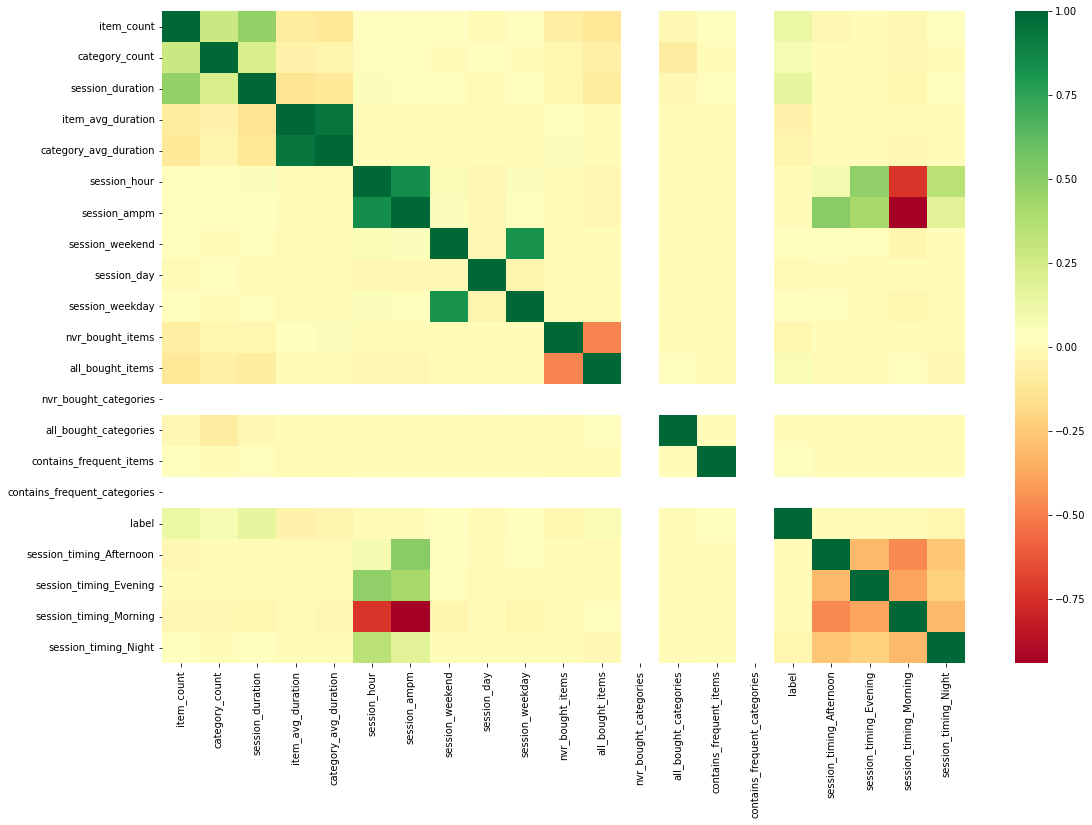

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (18,12))
sns.heatmap(encoded_df.corr(), cmap = 'RdYlGn')
plt.show()

Item count seems highly correlated with session duration.

We can plot the above plot in more subtle way

In [ ]:
encoded_df.drop('label', axis = 1).corrwith(encoded_df.label).sort_values().hvplot.barh(c = 'g', height = 450)

:Bars   [index]   (0)

We need to drop the `session_id` as it is redundant feature.

In [68]:
def feature_selection(df, train = True, redundant_cols=[]):

    df = df.reset_index()
    session_ids = df[['session_id']]
    if len(redundant_cols):
        df = df.drop(redundant_cols, axis= 1)

    if train:
        y = df[['label']]
        X = df.drop("label", axis = 1)
        return X, y

    return df, session_ids


## Modeling

We are done with data preparation, we can move ahead with modeling. Since this is a binary classification problem, I am using `scikit-learn` as the backend for following models.

- Logistic Regression
- Naive Bayes Classifier
- Decision Tree Classifier
- Random Forest Classifier
- XGB Classifier
- AdaBoost Classifier
- LGBM Classifier

I will be evaluating these models over default setting and since we need to optimize the weighted `f1-score` for this use case I will be monitering that.

I am using k-fold(k=3) cross validation technique to get average error and performance since it will give better estimate than 1-fold cv.

Also data is biased against a particular label, I am using oversampling technique call `SMOTE` to make sure we have equal representation of labels.

`SMOTE` creates artificial data for minority label if we want to do oversampling and by doing so it makes sure that we have equal number of label type in over sampled dataset.

I will be comparing the performance over `original data` and `oversampled data`.

In [ ]:
classifiers = {
    'Logistic Regression' : LogisticRegression(),
    'Naive Bayes Classifier': GaussianNB(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'XGB Classifier': XGBClassifier(eval_metric = 'logloss'),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'LGBM Classifier': LGBMClassifier()
}

## Model Evaluation/Selection

In [ ]:
X = encoded_df.drop('label', axis = 1)
y = encoded_df['label']

In [ ]:
#imabalane dataset
skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
scaler = StandardScaler()

d1 = []

#indeces and columns for classification report
ind = ['precision', 'recall', 'f1-score', 'support']
cols = ['0', '1', 'accuracy','macro avg', 'weighted avg']

#iterate over each classifier

for name, clf in classifiers.items():
    #d1 - store performance over original distribution
    #d2 - for oversampled distribution
    d1 = []
    d2 = []
    for train_ind, valid_ind in skf.split(X, y):

        X.iloc[train_ind] = scaler.fit_transform(X.iloc[train_ind])
        X.iloc[valid_ind] = scaler.transform(X.iloc[valid_ind])
        #fit and predict
        clf.fit(X.iloc[train_ind], y.iloc[train_ind])
        y_train_pred = clf.predict(X.iloc[train_ind])
        y_valid_pred = clf.predict(X.iloc[valid_ind])
        #resamples only minority label
        x_oversampled, y_oversampled = SMOTE(
            sampling_strategy = 'minority', random_state = 42).fit_resample(X.iloc[train_ind], y.iloc[train_ind])
        clf.fit(x_oversampled, y_oversampled)
        y_valid_pred_oversampled = clf.predict(X.iloc[valid_ind])

        d3 = classification_report(y.iloc[valid_ind], y_valid_pred, output_dict = True)
        d4 = classification_report(y.iloc[valid_ind], y_valid_pred_oversampled, output_dict = True)

        d1.append(d3)
        d2.append(d4)
    #Dataframe containing the classification report for all 3-folds for imbalanced/oversampled data
    temp_df_1 = pd.DataFrame(d1, columns = cols)
    temp_df_2 = pd.DataFrame(d2, columns = cols)

    #del report_1, report_2
    #classification report
    report_1 = pd.DataFrame(index = ind, columns = cols)
    report_2 = pd.DataFrame(index = ind, columns = cols)

    for index in ind:
        for col in temp_df_1:
            #del g1, g2
            #containing the values for each index(accuracy, precision, etc) in 3-folds for a speicific col in imbalanced data
            g1 = []
            g2 = []
            if col == 'accuracy':
                report_1.loc[index,col] = np.mean(temp_df_1[col])
                report_2.loc[index,col] = np.mean(temp_df_2[col])
                continue
            #exctracting the data for each index (accuracy, precison, etc)
            g1.append(temp_df_1[col].apply(lambda x: x[index]))
            g2.append(temp_df_2[col].apply(lambda x: x[index]))
            #Taking the mean for 3-folds
            report_1.loc[index,col] = np.mean(g1)
            report_2.loc[index,col] = np.mean(g2)

    print('classification report for', name, 'with imbalanced data:' )
    print(report_1)
    print('')
    print('classification report for', name, 'with oversampled data:' )
    print(report_2)
    print('')
    print('===============================================================')

classification report for Logistic Regression with imbalanced data:
                       0             1 accuracy macro avg weighted avg
precision       0.945044      0.422413  0.94398  0.683729     0.915932
recall          0.998756      0.015415  0.94398  0.507085      0.94398
f1-score        0.971158      0.029745  0.94398  0.500451     0.918718
support    354111.333333  20888.666667  0.94398  375000.0     375000.0

classification report for Logistic Regression with oversampled data:
                       0             1  accuracy macro avg weighted avg
precision       0.969725      0.113911  0.708654  0.541818     0.922053
recall          0.714101      0.616313  0.708654  0.665207     0.708654
f1-score        0.820882      0.191318  0.708654    0.5061     0.785814
support    354111.333333  20888.666667  0.708654  375000.0     375000.0

classification report for Naive Bayes Classifier with imbalanced data:
                       0             1 accuracy macro avg weighted avg
prec

It seems like **SMOTE** is increasing the precision and recall for minority class in almost with all classifiers but at the cost of weighted f-1 score.

XGBoost with oversampling seems performing better than any other classfier. And RandomForest without any oversampling seems to have descent perform.

I am not using `SMOTE` based oversampling because in all cases it is affecting the `wighted f1-score, I am carrying forwrd the analysis with original dataset(imbalanced data).


## Model's hyper-parameter tuning

Considering the `F1-score`, `precision score`, I am choosing Random Forest Classifier as a base classifier but it will be better to test DecisionTreeClassifier and Logistic Regressor to tune.

We can tune its hyper parameters to get the optimal performance.

In [ ]:
X_encoded.columns

Index(['item_count', 'category_count', 'session_duration', 'item_avg_duration',
       'category_avg_duration', 'session_hour', 'session_ampm',
       'session_weekend', 'session_day', 'session_weekday', 'nvr_bought_items',
       'all_bought_items', 'nvr_bought_categories', 'all_bought_categories',
       'contains_frequent_items', 'contains_frequent_categories',
       'session_timing_Afternoon', 'session_timing_Evening',
       'session_timing_Morning', 'session_timing_Night'],
      dtype='object')

In [ ]:
#get the data
X_train = data_loader(train_path)

X_features = feature_extraction(X_train, '', True)
#encode the features
X_encoded = encode_df(X_features)

X, y = feature_selection(X_encoded, True, ['session_id'])

/var/folders/xf/gcbfh98s6n53wh5f2hpb84nh0000gn/T/ipykernel_27059/3077538826.py:2: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  X_train = data_loader(train_path)


Index(['min_timestamp', 'max_timestamp', 'category_set', 'item_set', 'label'], dtype='object')


Define hyper-parameters for all three classifiers.

In [ ]:
hyperparameters = {
    'Logistic Regression':{
                            'penalty': ['l1', 'l2'], 'C':[0.01, 0.1, 1]
                            },
    'Decision Tree Classifier':{
                                'criterion': ['gini', 'entropy'], 'max_depth': list(range(50,200,20))

                                },
    'Random Forest Classifier':  {
        'n_estimators': [100, 200]
}
}

**Hyper-parameter tuning**

In [ ]:
%%time

cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 34)
clfs = []
for clf, hyperparam in hyperparameters.items():
    estimator = classifiers.get(clf)
    grid = GridSearchCV(estimator, hyperparam, cv = cv)
    grid.fit(X, y)
    best_hyperparams = grid.best_params_
    clfs.append(grid.best_estimator_)
    print('The best hyperparameters for', clf, ':', best_hyperparams, 'with r2 score: %0.1f' %(grid.best_score_))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

The best hyperparameters for Logistic Regression : {'C': 1, 'penalty': 'l2'} with r2 score: 0.9
The best hyperparameters for Decision Tree Classifier : {'criterion': 'entropy', 'max_depth': 50} with r2 score: 0.9


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KeyboardInterrupt: ignored

- The best hyperparameters for Logistic Regression : {'C': 1, 'penalty': 'l2'} with r2 score: 0.9
- The best hyperparameters for Decision Tree Classifier : {'criterion': 'entropy', 'max_depth': 50} with r2 score: 0.9
- The best hyperparameters for Random Forest Classifier : {'n_estimators':250} with r2 score: 0.92

## Predictions over Test set

We are done with model selctions and hyper-parameter tuning.

Now we can test out the model's performance over test dataset.

- First we need to train the model with best hyper-parameters on whole train data.
- Load the tests and do same preprocessing and all
- Make predictions and submission

**Load the train data and do processing**

In [ ]:
#get the data
X_train = data_loader(train_path)

X_features = feature_extraction(X_train, '', True)
#encode the features
X_encoded = encode_df(X_features)


X_train, y_train = feature_selection(X_encoded, True, ['session_id','session_hour', 'session_day'])

/var/folders/xf/gcbfh98s6n53wh5f2hpb84nh0000gn/T/ipykernel_27059/831701987.py:2: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  X_train = data_loader(train_path)


Index(['min_timestamp', 'max_timestamp', 'category_set', 'item_set', 'label'], dtype='object')


**Load the test data and do processing**

In [ ]:
#get the data
X_test = data_loader(test_path)
X_features = feature_extraction(X_test, '', False)
#encode the features
X_encoded = encode_df(X_features, False)
X_test, session_id = feature_selection(X_encoded, False, ['session_id','session_hour', 'session_day'])

Index(['min_timestamp', 'max_timestamp', 'category_set', 'item_set'], dtype='object')


In [ ]:
X_test

,item_count,category_count,session_duration,item_avg_duration,category_avg_duration,session_ampm,session_weekend,session_weekday,nvr_bought_items,all_bought_items,nvr_bought_categories,all_bought_categories,contains_frequent_items,contains_frequent_categories,session_timing_Afternoon,session_timing_Evening,session_timing_Morning,session_timing_Night
0,3,1,89,0.033708,0.011236,0,0,1,0,1,0,1,0,0,0,0,0,1
1,1,1,84,0.011905,0.011905,0,0,1,0,1,0,1,0,0,0,0,0,1
2,1,1,0,0.000000,0.000000,0,0,1,0,1,0,1,0,0,0,0,0,1
3,3,1,173,0.017341,0.005780,0,0,1,0,0,0,1,0,0,0,0,0,1
4,2,1,222,0.009009,0.004505,0,0,1,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306820,2,1,69,0.028986,0.014493,0,0,4,0,0,0,1,0,0,0,0,1,0
306821,3,1,180,0.016667,0.005556,1,0,4,0,1,0,1,0,0,0,0,0,1
306822,1,1,0,0.000000,0.000000,1,0,2,0,0,0,1,0,0,1,0,0,0
306823,14,5,4060,0.003448,0.001232,0,0,1,0,0,0,1,0,0,0,0,0,1


**Define the models**

In [ ]:
best_classifiers = {
    'Decision Tree Classifier': DecisionTreeClassifier(criterion= 'entropy', max_depth = 50),
    'Random Forest Classifier': RandomForestClassifier(n_estimators = 250)
}

****

**Training over whole data**

Train the instances and save it for prediction

In [ ]:
trained_clfs = {}

for k, v in best_classifiers.items():

    print(k)
    clf =  v
    clf.fit(X_train, y_train)
    trained_clfs[k] = clf


**Prediction over test data**

In [ ]:
for k, v in trained_clfs.items():
    print(k)
    y_pred = v.predict(X_test)
    res = pd.DataFrame({"session_id":session_id.values.flatten(), 'label':y_pred})
    res.to_csv(k+'_final_file.csv', index=False)
    print(res['label'].value_counts())

Decision Tree Classifier
0    303758
1      3067
Name: label, dtype: int64
Random Forest Classifier
0    304787
1      2038
Name: label, dtype: int64


----

# Multilayer perceptron based Neural Network Model

We have already prepared the data, we can use same data to train a neural network based model. I will be using pytorch as a backend.

## Contents

- Imports
- Data Preparation
- Train/Test split
- Model Building
- Model Training
- Model Evaluation
- Test predictions
- Submission

## Imports

In [69]:
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

## Data preparation

Since we have already defined all the helper functions for data preparation we can use the directly here. Like classicla machine learning model, neural networks also expects the input in integer format.

We need to standardize the continous variables in out data to speed the smooth training.

### Load the data

In [70]:
#load the train data

#get the data
X = data_loader(train_path)

X_features = feature_extraction(X, '/content/', True)
#encode the features
X_encoded = encode_df(X_features)


X, y = feature_selection(X_encoded, True, ['session_id','session_hour', 'session_day'])


<ipython-input-7-90e6d352ef11>:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, delimiter=delimiter, parse_dates=True)


Index(['min_timestamp', 'max_timestamp', 'category_set', 'item_set', 'label'], dtype='object')


### Feature selection

In [71]:
#seggregate continous features and categorical ones
cats = ['session_ampm', 'session_weekend', 'session_weekday', 'nvr_bought_items',
       'all_bought_items', 'nvr_bought_categories', 'all_bought_categories',
       'contains_frequent_items', 'contains_frequent_categories',
       'session_timing_Afternoon', 'session_timing_Evening',
       'session_timing_Morning', 'session_timing_Night']

cont = ['item_count', 'category_count', 'session_duration', 'item_avg_duration',
       'category_avg_duration']




### Train/Valid split

In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

In [73]:
X_train_cat = X_train[cats].values
X_train_cont = X_train[cont].values

X_valid_cat = X_valid[cats].values
X_valid_cont = X_valid[cont].values

**Converth them into tensots**

In [74]:
X_train_cat = torch.tensor(X_train_cat, dtype=torch.int32)
X_train_cont = torch.tensor(X_train_cont, dtype=torch.float32)
X_valid_cat = torch.tensor(X_valid_cat, dtype=torch.int32)
X_valid_cont = torch.tensor(X_valid_cont, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.int64).flatten()
y_valid = torch.tensor(y_valid.values, dtype=torch.int64).flatten()


## Model Building

Since we are done with all kind of preprocessing that one should performed before feeding the values to neural networks. It's time to build a model wich can take the input and come up with possible classes.

Since we are working with Tabular Data, I will be using Linear layers and for categorical columns Embedding Layer is preferable before feeding them to Linear layers.

Since this is a classification problem and only two values are possible either 0 and 1, I am gonna use nn.CrossEntropyLoss(y_pred, y_true) as loss functions.

For updating the parameters after backpropagation, I am using torch.optim.Adam(model.parameters(), lr=lr) as a optimizer.

Final Model Structures:

- A batch normalization layer for continous variables.
- Concat categorical values and normalized values of continous values
- A Linear layer having dimension of (input_size, 100)
- Relu activation function
- Dropout layer(p=0.4)
- A linear layer having dimension of (100, 50)
- Relu activation function
- Dropout layer(p=0.4)
- A sigmoid function

In [75]:
class Classifier(nn.Module):

    def __init__(self, n_cat, n_cont, layers, out_sz, p=0.5):
        super().__init__()
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_in = n_cont+n_cat
        layerslist = []

        for layer_size in layers:
            layerslist.append(nn.Linear(n_in, layer_size))
            layerslist.append(nn.ReLU(inplace=True))
            layerslist.append(nn.Dropout1d(p))
            n_in = layer_size
        #append sigmoid function as well
        layerslist.append(nn.Linear(layers[-1], out_sz))
        self.resultant_struct = nn.Sequential(*layerslist)

    def forward(self, conts, cats):
        #batch normalization for conts
        conts = self.bn_cont(conts)
        #concat both in single variable X
        X = torch.cat([conts, cats], 1)

        return self.resultant_struct(X)

**Define an instance of the above model**

In [76]:
model  = Classifier(len(cats), len(cont), [100, 50], 2, 0.4)

### Define loss functions and optimizer

Here we are using nn.CrossEntropyLoss() as a loss function and torch.optim.Adam() as an optimizer.

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Model's Traning

We are done with modelsing part now it's time to show some data to model and reduce it's biasness

In [78]:
import time
start_time = time.time()

epochs = 300
train_losses = []
valid_losses = []

for i in range(epochs):
    #set model in train mode
    model.train()
    i+=1
    y_pred = model(X_train_cont, X_train_cat)
    loss = criterion(y_pred, y_train)
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    #validation loss
    #set model in eval mode
    model.eval()
    with torch.no_grad():
        y_valid_pred = model(X_valid_cont, X_valid_cat)
        valid_loss = criterion(y_valid_pred, y_valid)
        valid_losses.append(valid_loss.item())


print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.75034684
epoch:  26  loss: 0.55970514
epoch:  51  loss: 0.51077932
epoch:  76  loss: 0.47516784
epoch: 101  loss: 0.44318753
epoch: 126  loss: 0.41848898
epoch: 151  loss: 0.40032363
epoch: 176  loss: 0.38917872
epoch: 201  loss: 0.38019648
epoch: 226  loss: 0.37285596
epoch: 251  loss: 0.36674520
epoch: 276  loss: 0.36070827
epoch: 300  loss: 0.35560477

Duration: 1302 seconds


## Model's Evaluation

### Train loss vs Validation loss

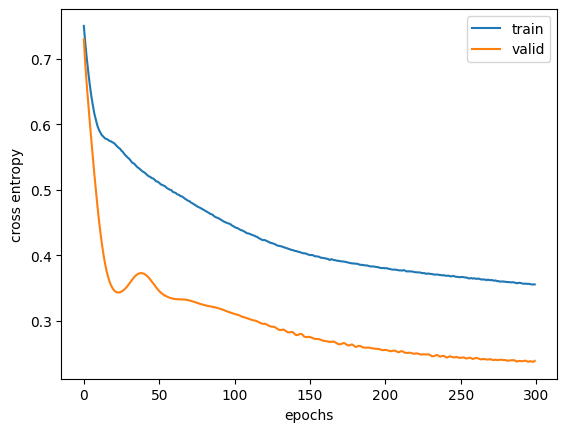

In [79]:
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

## Model's Inference

### Prepare test set

In [80]:
#get the data
X = data_loader(test_path)

X_features = feature_extraction(X, '/content/', False)
#encode the features
X_encoded = encode_df(X_features, False)


X_test,session_ids  = feature_selection(X_encoded, False, ['session_id','session_hour', 'session_day'])

cats = ['session_ampm', 'session_weekend', 'session_weekday', 'nvr_bought_items',
       'all_bought_items', 'nvr_bought_categories', 'all_bought_categories',
       'contains_frequent_items', 'contains_frequent_categories',
       'session_timing_Afternoon', 'session_timing_Evening',
       'session_timing_Morning', 'session_timing_Night']

cont = ['item_count', 'category_count', 'session_duration', 'item_avg_duration',
       'category_avg_duration']

X_test_cat = X_test[cats].values
X_test_cont = X_test[cont].values

X_test_cat = torch.tensor(X_test_cat, dtype=torch.int32)
X_test_cont = torch.tensor(X_test_cont, dtype=torch.float32)



Index(['min_timestamp', 'max_timestamp', 'category_set', 'item_set'], dtype='object')


### Prediction

In [ ]:
y_pred = model(X_test_cont, X_test_cat)

In [ ]:
y_pred = y_pred.argmax(dim=1).tolist()

## Final Submission

In [85]:
result = pd.DataFrame({"session_id":session_ids.values.flatten(), "label":y_pred})

In [ ]:
result['label'].value_counts()

Save the file for submission.

In [ ]:
result.to_csv("nn_result.csv", index=False)

----

**That's All in this notebook...thanks!**